In [1]:
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import geopandas
import geoplot
import geoplot.crs as gcrs

import rasterio
import rioxarray

import json
import seaborn as sns

In [2]:
yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_data.csv')
yield_data = yield_data.loc[(yield_data['product'] == 'Maize')]
kenya_data = yield_data.loc[yield_data['country'] == 'Kenya']

In [3]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
adm_data = adm_data.explode()#.crs
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data_for_merging = adm_data.drop_duplicates(subset = ['fnid']).drop(columns=['admin_1', 'admin_2', 'start_date', 'id'])
yield_data_polygons = adm_data_for_merging.merge(yield_data, on=['fnid'], how='right')#yield_data.merge(, on=['fnid'], how='left')#, validate='one_to_many')

Skipping field centroid: unsupported OGR type: 3


In [5]:
temp_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\temp_SSA_1999_2008.nc')

In [4]:
xds = rioxarray.open_rasterio('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\temp_SSA_1999_2008.nc')

In [5]:
xds = xds.rio.write_crs('EPSG:4326')

In [6]:
yield_data_mean = yield_data.loc[(yield_data['country'] == 'Kenya')].dropna()
yield_data_mean = yield_data_mean.loc[:, ['admin_1', 'yield']].groupby('admin_1').mean()
yield_data_mean = adm_data_for_merging.merge(yield_data_mean, left_on=['name'], right_on = ['admin_1'], how='right')

In [109]:
clipped = xds['t2m'].isel(time=10).rio.clip(yield_data_mean.iloc[[30], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=False)#adm_data.iloc[10, :].geometry.exterior.coords

In [9]:
for region_index in list(range(1, 21)) + list(range(22, 50)):
    print(region_index)
    adm1_name = yield_data_mean.iloc[region_index, 1]
    print(adm1_name)
    clipped = xds.rio.clip(yield_data_mean.iloc[[region_index], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=True)#adm_data.iloc[10, :].geometry.exterior.coords
    clipped.to_netcdf(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Temp\\{adm1_name}_1999_2008.nc')
    #print(len(clipped.values[~np.isnan(clipped.values)]))
    #clipped2 = xds['t2m'].isel(time=10).rio.clip(yield_data_mean.iloc[[region_index], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=False)#adm_data.iloc[10, :].geometry.exterior.coords
    #if len(clipped2.values[~np.isnan(clipped2.values)]) != len(clipped.values[~np.isnan(clipped.values)]):
    #    print(clipped2.values[~np.isnan(clipped2.values)])

1
Bomet
2
Bungoma
3
Busia
4
Elgeyo-Marakwet
5
Embu
6
Garissa
7
Homa Bay
8
Isiolo
9
Kajiado
10
Kakamega
11
Kericho
12
Kiambu
13
Kiambu
14
Kilifi
15
Kirinyaga
16
Kisii
17
Kisumu
18
Kitui
19
Kwale
20
Laikipia
22
Machakos
23
Makueni
24
Makueni
25
Mandera
26
Marsabit
27
Meru
28
Migori
29
Mombasa
30
Murang'a
31
Nairobi
32
Nakuru
33
Nandi
34
Narok
35
Nyamira
36
Nyandarua
37
Nyeri
38
Samburu
39
Siaya
40
Taita Taveta
41
Tana River
42
Tharaka Nithi
43
Trans Nzoia
44
Turkana
45
Uasin Gishu
46
Vihiga
47
Vihiga
48
Wajir
49
West Pokot


In [69]:
adm_data.iloc[10, 15].to_json

AttributeError: 'Polygon' object has no attribute 'to_json'

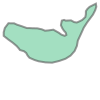

In [93]:
adm_data.iloc[10, :].geometry

In [16]:
ShapeMask = rasterio.features.geometry_mask(adm_data.iloc[0],
                                      out_shape=(len(xds['lat']), len(xds['lat'])),
                                      transform=xds.geobox.transform,
                                      invert=True)
ShapeMask = xr.DataArray(ShapeMask , dims=("y", "x"))

KeyError: "No variable named 'lat'. Variables on the dataset include ['x', 'y', np.str_('time'), 'spatial_ref', 't2m', 't2max', 't2min']"